# TAL M2 Apprentissage artificiel - Projet final

Hongying XU, Simeng SONG, Xiaobo WANG

## Introduction

Dans ce projet, nous réalisons la **tâche 3 du défi DEFT 2009**. L'objectif est de créer un classifieur capable de deviner le parti politique d'un orateur en analysant son discours au Parlement européen.

Nous utilisons 3 architectures, dont : 

- baseline : Naive Bayes
- Linéaire : Logistique Régression 
- Deep Learning : LSTM

Nous allons construire les 3 modèles et finalement comparer la performance de ces 3 modèles avec la visualisation.

In [29]:
import os
import glob
import numpy as np
import xml.etree.ElementTree as ET
import re
import time
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
import pandas as pd

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)


## Chargement des corpus

Dans cette section, nous chargons les différents fichiers de données :
- Corpus d'apprentissage : données XML pour l'entraînement du modèle
- Corpus de test : données XML pour l'évaluation
- Données de référence : fichiers texte contenant les labels (partis politiques)

Les données sont organisées en trois langues : anglais (en), français (fr) et italien (it).

In [30]:
DATA_DIR = os.path.expanduser("./deft09")

TRAIN_DIR = os.path.join(DATA_DIR, "Corpus d_apprentissage")
TEST_DIR  = os.path.join(DATA_DIR, "Corpus de test")
REF_DIR   = os.path.join(DATA_DIR, "Données de référence")

train_files = sorted(glob.glob(os.path.join(TRAIN_DIR, "*.xml")))
test_files  = sorted(glob.glob(os.path.join(TEST_DIR, "*.xml")))
ref_files   = sorted(glob.glob(os.path.join(REF_DIR, "*.txt")))

print("Train xml:", len(train_files), train_files)
print("Test  xml:", len(test_files), test_files[:3])
print("Ref   txt:", len(ref_files), ref_files[:3])

Train xml: 3 ['./deft09/Corpus d_apprentissage/deft09_parlement_appr_en.xml', './deft09/Corpus d_apprentissage/deft09_parlement_appr_fr.xml', './deft09/Corpus d_apprentissage/deft09_parlement_appr_it.xml']
Test  xml: 3 ['./deft09/Corpus de test/deft09_parlement_test_en.xml', './deft09/Corpus de test/deft09_parlement_test_fr.xml', './deft09/Corpus de test/deft09_parlement_test_it.xml']
Ref   txt: 3 ['./deft09/Données de référence/deft09_parlement_ref_en.txt', './deft09/Données de référence/deft09_parlement_ref_fr.txt', './deft09/Données de référence/deft09_parlement_ref_it.txt']


## Extraction des Labels comme Référence

On voudrait lire les fichiers de référence et crée un dictionnaire associant chaque document à son parti correspondant.

In [31]:
def get_id2label(ref_file_list):
    id2label = {}
    for fp in ref_file_list:
        with open(fp, "r", encoding="utf-8", errors="ignore") as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) >= 2:
                    # parts[0] = ID, parts[1] = parti
                    id2label[parts[0]] = parts[1]
    return id2label
    
id2label = get_id2label(ref_files)
print("Nb labels in reference:", len(id2label))
# voir exemples
print("Example:", list(id2label.items())[:5])

Nb labels in reference: 12917
Example: [('1', 'PPE-DE'), ('2', 'PPE-DE'), ('3', 'PPE-DE'), ('4', 'PPE-DE'), ('5', 'GUE-NGL')]


Et puis, cette fonction parcourt les fichiers XML et extrait les textes et les partis associé.
Par ailleurs, le texte est nettoyé en supprimant les espaces multiples et les caractères superflus.

In [32]:
def load_data_from_xml(xml_files, id2label_dict=None):
    texts = []
    labels = []
    
    for xml_path in xml_files:
        try:
            tree = ET.parse(xml_path)
            root = tree.getroot()
            
            for doc in root.findall(".//doc"):
                doc_id = doc.get("id")
                
                # extraction des textes
                texte_node = doc.find("texte")
                if texte_node is None: continue
                
                # nettoyer
                raw_text = "".join(texte_node.itertext())
                clean_text = re.sub(r"\s+", " ", raw_text).strip()
                if not clean_text: continue
                
                # extraction des labels
                label = None
                parti_node = doc.find(".//PARTI")
                if parti_node is not None:
                    label = parti_node.get("valeur")
                elif id2label_dict is not None:
                    # si il y a pas, chercher dans le dictionnaire de test
                    label = id2label_dict.get(doc_id)
                if label:
                    texts.append(clean_text)
                    labels.append(label)
                    
        except Exception as e:
            print(f"Erreur : {xml_path}: {e}")
            
    return texts, labels

In [33]:
id2label_dict = get_id2label(ref_files)

# chargement du set de train
train_texts, train_labels = load_data_from_xml(train_files)

# chargement du set de test
test_texts, test_labels = load_data_from_xml(test_files, id2label_dict)

print(f"Train Set : {len(train_texts)}")
print(f"Test Set : {len(test_texts)}")

Train Set : 58109
Test Set : 38743


Résultat est : 
- 58,109 textes d'entraînement
- 38,743 textes de test

## Encodage des Labels

On transforme les labels textuels en indices numériques, puis en vecteurs one-hot pour être utilisés par le réseau de neurones.

In [34]:
# label encoding
label_encoder = LabelEncoder()
y_train_idx = label_encoder.fit_transform(train_labels)
y_test_idx = label_encoder.transform(test_labels)

num_classes = len(label_encoder.classes_)
# one-hot encoding
y_train = to_categorical(y_train_idx, num_classes)
y_test = to_categorical(y_test_idx, num_classes)

In [35]:
# tokenization
MAX_VOCAB = 10000  # fixer le maximum de vocabulaire
MAX_LEN = 200      # garder 200 mots chaque phrase

tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(train_texts)

X_train_seq = tokenizer.texts_to_sequences(train_texts)
X_test_seq = tokenizer.texts_to_sequences(test_texts)

# Padding
X_train = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_test = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post', truncating='post')
print("Labels des partis:", label_encoder.classes_)

Labels des partis: ['ELDR' 'GUE-NGL' 'PPE-DE' 'PSE' 'Verts-ALE']


## Modèle : Naive Bayes

**Approche** :
- Utilisation de TF-IDF pour la vectorisation des textes
- MultinomialNB pour la classification multi-classes


In [36]:
X_train_nb, X_val_nb, y_train_nb, y_val_nb = train_test_split(
    train_texts, 
    train_labels, 
    test_size=0.2, 
    random_state=SEED, 
    stratify=train_labels
)

print(f"Train set: {len(X_train_nb)} échantillons")
print(f"Validation set: {len(X_val_nb)} échantillons")
print(f"Test set: {len(test_texts)} échantillons")

Train set: 46487 échantillons
Validation set: 11622 échantillons
Test set: 38743 échantillons


In [37]:
tfidf_vectorizer = TfidfVectorizer(
    max_features=10000,  
    ngram_range=(1, 2),   
    min_df=2,            
    max_df=0.95,         
    lowercase=True,
    strip_accents='unicode'
)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_nb)
X_val_tfidf = tfidf_vectorizer.transform(X_val_nb)
X_test_tfidf = tfidf_vectorizer.transform(test_texts)

print(f"Shape des données TF-IDF - Train: {X_train_tfidf.shape}")
print(f"Shape des données TF-IDF - Validation: {X_val_tfidf.shape}")
print(f"Shape des données TF-IDF - Test: {X_test_tfidf.shape}")


Shape des données TF-IDF - Train: (46487, 10000)
Shape des données TF-IDF - Validation: (11622, 10000)
Shape des données TF-IDF - Test: (38743, 10000)


In [38]:
# Utilisation de probabilités uniformes pour class_prior
uniform_prior = np.ones(len(np.unique(y_train_nb))) / len(np.unique(y_train_nb))

In [39]:
# création et entraînement du modèle
nb_model = MultinomialNB(alpha=1.0, class_prior=uniform_prior)
nb_model.fit(X_train_tfidf, y_train_nb)


,"alpha alpha: float or array-like of shape (n_features,), default=1.0Additive (Laplace/Lidstone) smoothing parameter(set alpha=0 and force_alpha=True, for no smoothing).",1.0
,"force_alpha force_alpha: bool, default=TrueIf False and alpha is less than 1e-10, it will set alpha to1e-10. If True, alpha will remain unchanged. This may causenumerical errors if alpha is too close to 0... versionadded:: 1.2.. versionchanged:: 1.4 The default value of `force_alpha` changed to `True`.",True
,"fit_prior fit_prior: bool, default=TrueWhether to learn class prior probabilities or not.If false, a uniform prior will be used.",True
,"class_prior class_prior: array-like of shape (n_classes,), default=NonePrior probabilities of the classes. If specified, the priors are notadjusted according to the data.","array([0.2, 0....2, 0.2, 0.2])"


In [40]:
# évaluation sur test set
y_test_pred = nb_model.predict(X_test_tfidf)
y_test_pred_idx = label_encoder.transform(y_test_pred)

print(classification_report(test_labels, y_test_pred, target_names=label_encoder.classes_))


              precision    recall  f1-score   support

        ELDR       0.15      0.16      0.16      4016
     GUE-NGL       0.23      0.36      0.28      5383
      PPE-DE       0.43      0.32      0.37     13710
         PSE       0.32      0.29      0.31     10880
   Verts-ALE       0.18      0.23      0.20      4754

    accuracy                           0.29     38743
   macro avg       0.26      0.27      0.26     38743
weighted avg       0.31      0.29      0.30     38743



## Visualisation


### F1-score par classe


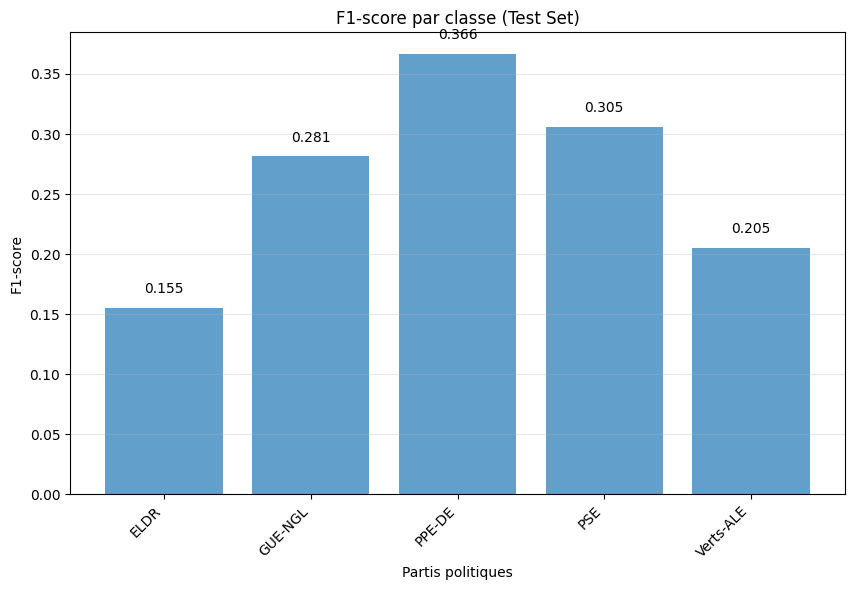

In [43]:
# Extraction des F1-scores par classe
report = classification_report(test_labels, y_test_pred, 
                               target_names=label_encoder.classes_, 
                               output_dict=True, zero_division=0)

classes = label_encoder.classes_
f1_scores = [report[cls]['f1-score'] for cls in classes]

plt.figure(figsize=(10, 6))
plt.bar(classes, f1_scores, alpha=0.7)
plt.xlabel('Partis politiques')
plt.ylabel('F1-score')
plt.title('F1-score par classe (Test Set)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# Ajouter les valeurs sur les barres
for i, v in enumerate(f1_scores):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=10)

plt.show()

### Confusion Matrix


<Figure size 1000x800 with 0 Axes>

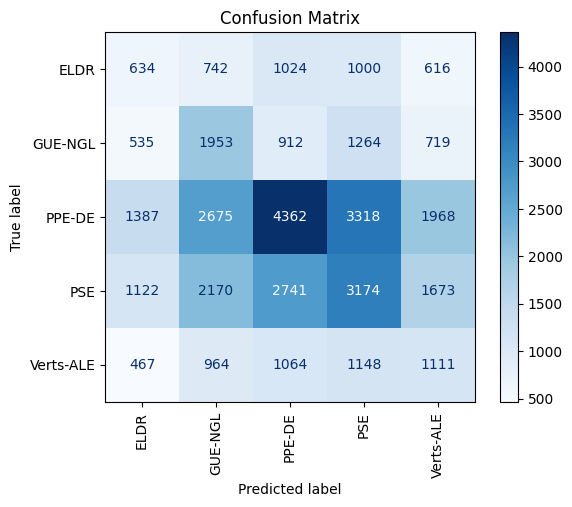

In [41]:
cm = confusion_matrix(test_labels, y_test_pred)

plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical', values_format='d')
plt.title("Confusion Matrix")
plt.show()


## Modèle : LSTM

### 3 Coches principales : 

1. Couche Embedding (100 dimensions)

2. Couche LSTM (64 unités)

3. Couche Dense (softmax)

In [16]:
# création du modèle
model = models.Sequential([
    layers.Embedding(input_dim=MAX_VOCAB, output_dim=100, input_length=MAX_LEN),
    
    layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2),

    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy', # classification multi-classe
              metrics=['accuracy'])

/home/sibel/mlenv/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:100: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2025-12-28 15:31:32.144987: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [17]:
# entraînement du modèle
history = model.fit(X_train, y_train,
                    epochs=10, # j'ai augmenté les epochs car l'accuracy n'est pas très bien
                    batch_size=32,
                    validation_data=(X_test, y_test)) 

Epoch 1/10
1816/1816 ━━━━━━━━━━━━━━━━━━━━ 176s 95ms/step - accuracy: 0.3540 - loss: 1.4886 - val_accuracy: 0.3528 - val_loss: 1.4916
Epoch 2/10
1816/1816 ━━━━━━━━━━━━━━━━━━━━ 173s 96ms/step - accuracy: 0.3846 - loss: 1.4320 - val_accuracy: 0.3479 - val_loss: 1.5104
Epoch 3/10
1816/1816 ━━━━━━━━━━━━━━━━━━━━ 173s 95ms/step - accuracy: 0.4474 - loss: 1.3137 - val_accuracy: 0.3539 - val_loss: 1.5862
Epoch 4/10
1816/1816 ━━━━━━━━━━━━━━━━━━━━ 173s 95ms/step - accuracy: 0.5181 - loss: 1.1690 - val_accuracy: 0.3570 - val_loss: 1.7070
Epoch 5/10
1816/1816 ━━━━━━━━━━━━━━━━━━━━ 173s 95ms/step - accuracy: 0.5739 - loss: 1.0422 - val_accuracy: 0.3571 - val_loss: 1.8409
Epoch 6/10
1816/1816 ━━━━━━━━━━━━━━━━━━━━ 173s 95ms/step - accuracy: 0.6265 - loss: 0.9289 - val_accuracy: 0.3568 - val_loss: 1.9839
Epoch 7/10
1816/1816 ━━━━━━━━━━━━━━━━━━━━ 173s 95ms/step - accuracy: 0.6714 - loss: 0.8261 - val_accuracy: 0.3571 - val_loss: 2.2131
Epoch 8/10
1816/1816 ━━━━━━━━━━━━━━━━━━━━ 174s 96ms/step - accuracy: 

In [18]:
# évaluation sur test set
y_pred = model.predict(X_test)
y_pred_ids = np.argmax(y_pred, axis=1)

print(classification_report(y_test_idx, y_pred_ids, target_names=label_encoder.classes_))

1211/1211 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step
              precision    recall  f1-score   support

        ELDR       0.24      0.24      0.24      4016
     GUE-NGL       0.35      0.31      0.33      5383
      PPE-DE       0.44      0.46      0.45     13710
         PSE       0.37      0.40      0.38     10880
   Verts-ALE       0.27      0.21      0.24      4754

    accuracy                           0.37     38743
   macro avg       0.33      0.33      0.33     38743
weighted avg       0.37      0.37      0.37     38743



## Visualisation

### Learning Curves

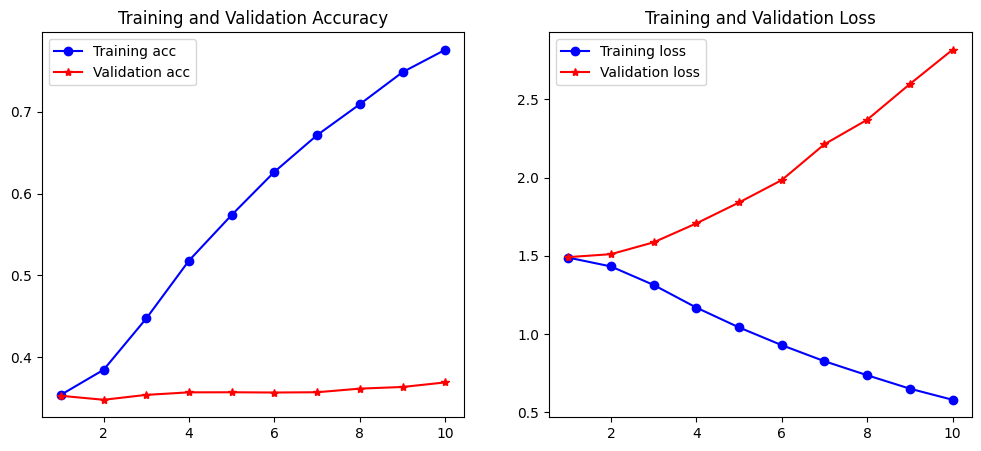

In [20]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    # accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training acc')
    plt.plot(epochs, val_acc, 'r*-', label='Validation acc')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'r*-', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()
    
plot_history(history)

### Confusion Matrix

<Figure size 2000x2000 with 0 Axes>

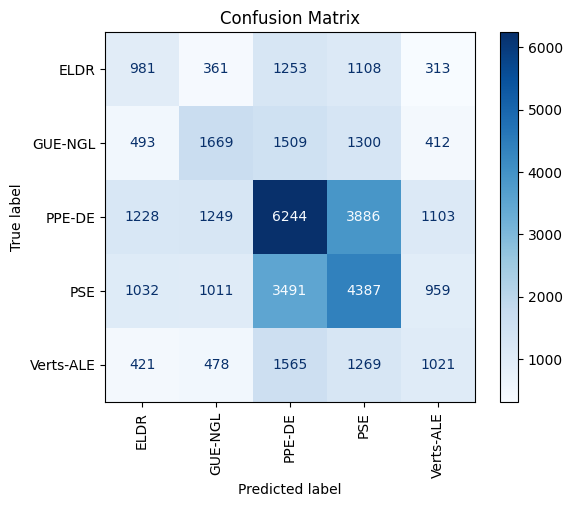

In [21]:

cm = confusion_matrix(y_test_idx, y_pred_ids)

plt.figure(figsize=(20, 20))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)

disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical', values_format='d')

plt.title("Confusion Matrix")
plt.show()